<a href="https://colab.research.google.com/github/Inno732/Defi_IA_1_2023_2024/blob/main/defis_1_new_databases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
!rm -rf sample_data

Mon Oct 30 13:18:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.src.applications import VGG19
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)

Tensorflow version: 2.14.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [3]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [4]:
!rm -rf sample_data
#! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/QP7FoyttxJgS8Cj/download/small.zip
#! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/REWbK6K4XRtoeNw/download/FIRE_DATABASE_1.zip
#! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/KaqzczZsXfsnMER/download/FIRE_DATABASE_2.zip
! wget --no-check-certificate https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_3.zip
#! unzip small.zip -d 'bases'
#! unzip FIRE_DATABASE_1.zip -d 'bases'
#! unzip FIRE_DATABASE_2.zip -d 'bases'
! unzip FIRE_DATABASE_3.zip -d 'bases'
#! rm small.zip
#! rm FIRE_DATABASE_1.zip
#! rm FIRE_DATABASE_2.zip
! rm FIRE_DATABASE_3.zip

--2023-10-30 13:18:39--  https://nextcloud.ig.umons.ac.be/s/faKyDy7LCxfz9Xk/download/FIRE_DATABASE_3.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1151508462 (1.1G) [application/zip]
Saving to: ‘FIRE_DATABASE_3.zip’

FIRE_DATABASE_3.zip 100%[===================>]   1.07G  29.6MB/s    in 40s     

2023-10-30 13:19:20 (27.8 MB/s) - ‘FIRE_DATABASE_3.zip’ saved [1151508462/1151508462]

Archive:  FIRE_DATABASE_3.zip
   creating: bases/FIRE_DATABASE_2/
   creating: bases/FIRE_DATABASE_2/fire/
  inflating: bases/FIRE_DATABASE_2/fire/00000000 copie 10.jpg  
  inflating: bases/FIRE_DATABASE_2/fire/00000000 copie 11.jpg  
  inflating: bases/FIRE_DATABASE_2/fire/00000000 copie 12.jpg  
  inflating: bases/FIRE_DATABASE_2/fire/00000000 copie 13.jpg  
  inflating: bases/FIRE_DATABASE_2/fire/00000000 copie 14

#**4. Téléchargement des données de test "Test Dataset"**

In [5]:
!rm -rf sample_data
!wget https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
!unzip test.zip -d 'bases'
!rm test.zip

--2023-10-30 13:19:33--  https://nextcloud.ig.umons.ac.be/s/RsZpqtYfDgYzKxr/download/test.zip
Resolving nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)... 193.190.209.220
Connecting to nextcloud.ig.umons.ac.be (nextcloud.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57038454 (54M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]  54.40M  21.0MB/s    in 2.6s    

2023-10-30 13:19:37 (21.0 MB/s) - ‘test.zip’ saved [57038454/57038454]

Archive:  test.zip
   creating: bases/test/
   creating: bases/test/fire/
  inflating: bases/test/fire/F_1001.jpg  
  inflating: bases/test/fire/F_2062.jpg  
  inflating: bases/test/fire/F_2063.jpg  
  inflating: bases/test/fire/F_2064.jpg  
  inflating: bases/test/fire/F_2066.jpg  
  inflating: bases/test/fire/F_2067.jpg  
  inflating: bases/test/fire/F_2068.jpg  
  inflating: bases/test/fire/F_2070.jpg  
  inflating: bases/test/fire/F_2071.jpg  
  inflat

#**5. Création du fichier de labels "classes.txt"**

In [6]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [7]:
nb_classes = 3
batch_size=4 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=10 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}
dataset_name='FIRE_DATABASE_2' #@param ["small","FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = "VGG16" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [8]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size= (299, 299),      # Taille des images d'entrée
	batch_size= batch_size,      # Taille du mini-batch
  label_mode= 'categorical'    # Conversion au format One-Hot
)                             # Generates a 'tf.data.Dataset' from image files in a directory (train_dataset)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dataset,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)
print(val_ds.class_names)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.
['fire', 'no_fire', 'start_fire']


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [ ]:
model_xception = Xception(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_xception.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dense(512, activation='sigmoid')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_xception = Model(inputs = model_xception.inputs, outputs=predictions)


In [11]:
model_VGG16 = VGG16(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_VGG16.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG16 = Model(inputs = model_VGG16.inputs, outputs=predictions)


58889256/58889256 [==============================] - 0s 0us/step


In [13]:
model_VGG19 = VGG19(include_top = False, weights='imagenet', input_shape=(299, 299, 3))

# create a custom top classifier
x = model_VGG19.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_VGG19 = Model(inputs = model_VGG19.inputs, outputs=predictions)


80134624/80134624 [==============================] - 0s 0us/step


In [12]:
model_InceptionV3 = InceptionV3(include_top=False, weights="imagenet",input_shape=(299,299,3))
x = model_InceptionV3.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_InceptionV3 = Model(inputs = model_InceptionV3.inputs, outputs=predictions)

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
model_inceptionResnetV2 = InceptionResNetV2(include_top=False,weights="imagenet",input_shape=(299,299,3))
x = model_inceptionResnetV2.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name="flatten")(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1072, activation='relu')(x)
x = Dropout(0.2)(x)
#x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model_inceptionResnetV2 = Model(inputs = model_inceptionResnetV2.inputs, outputs=predictions)

219055592/219055592 [==============================] - 1s 0us/step


# **10.1 Analyser/visualiser l'architecture de votre modèle avec la fonction summary()**

# **11. Geler puis dégeler les poids des premières couches**

In [15]:
for layer in model_xception.layers:
        layer.trainable = True

NameError: ignored

In [16]:
for layer in model_VGG16.layers:
        layer.trainable = True

In [17]:
for layer in model_VGG19.layers:
        layer.trainable = True

In [18]:
for layer in model_InceptionV3.layers:
        layer.trainable = True

In [19]:
for layer in model_inceptionResnetV2.layers:
        layer.trainable = True

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [ ]:
model_xception.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [21]:
model_VGG16.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [22]:
model_VGG19.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [23]:
model_InceptionV3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [24]:
model_inceptionResnetV2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [25]:
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0     

In [26]:
model_VGG19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

In [27]:
model_xception.summary()

NameError: ignored

# **12. Entraîner le modèle**

In [ ]:
history_xception=model_xception.fit(
    train_ds,
#    steps_per_epoch=math.ceil(len(train_ds)),
    epochs=epochs,
    validation_data=val_ds,
 #   validation_steps=math.ceil(len(val_ds)),
#    verbose=1
)

In [ ]:
history_VGG16=model_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
)

Epoch 1/10
300/300 [==============================] - 71s 180ms/step - loss: 0.1509 - categorical_accuracy: 0.9542 - val_loss: 6.8883e-04 - val_categorical_accuracy: 1.0000
Epoch 2/10
300/300 [==============================] - 50s 167ms/step - loss: 4.9166e-04 - categorical_accuracy: 1.0000 - val_loss: 1.7107e-04 - val_categorical_accuracy: 1.0000
Epoch 3/10
300/300 [==============================] - 52s 171ms/step - loss: 2.5198e-04 - categorical_accuracy: 1.0000 - val_loss: 7.3178e-05 - val_categorical_accuracy: 1.0000
Epoch 4/10
300/300 [==============================] - 51s 167ms/step - loss: 1.8371e-04 - categorical_accuracy: 1.0000 - val_loss: 4.5064e-05 - val_categorical_accuracy: 1.0000
Epoch 5/10
300/300 [==============================] - 51s 167ms/step - loss: 6.7797e-05 - categorical_accuracy: 1.0000 - val_loss: 3.2747e-05 - val_categorical_accuracy: 1.0000
Epoch 6/10
300/300 [==============================] - 52s 171ms/step - loss: 5.7196e-05 - categorical_accuracy: 1.0000 

In [ ]:
history_VGG19=model_VGG19.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
)

In [ ]:
model_inceptionResnetV2=model_inceptionResnetV2.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
)

In [ ]:
model_InceptionV3=model_InceptionV3.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
)

La fonction suivante permet d’afficher les poids d’une couche. Elle prend en paramètre le modèle et
le nom de la couche dont on souhaite afficher les poids.


In [ ]:
def affichePoids(model, name):
  print ("affichage des poids de la couche", name)

  #afficher les poids qui « arrivent » sur une couche
  WS = model.get_layer(name).get_weights()

  print("weights = ", WS[0] )
  print("biais = ", WS[1] )
  affichePoids(model_VGG16,Dense(1024,activation='relu'))

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [ ]:
model_xception.save("model_xception.h5")

In [26]:
model_VGG16.save("model_VGG16.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_VGG19.save("model_VGG19.h5")

In [27]:
model_InceptionV3.save("model_InceptionV3.h5")

AttributeError: ignored

In [28]:
model_inceptionResnetV2.save("model_inceptionResnetV2.h5")

AttributeError: ignored

##14. Diagramme des models

Text(0, 0.5, 'loss')

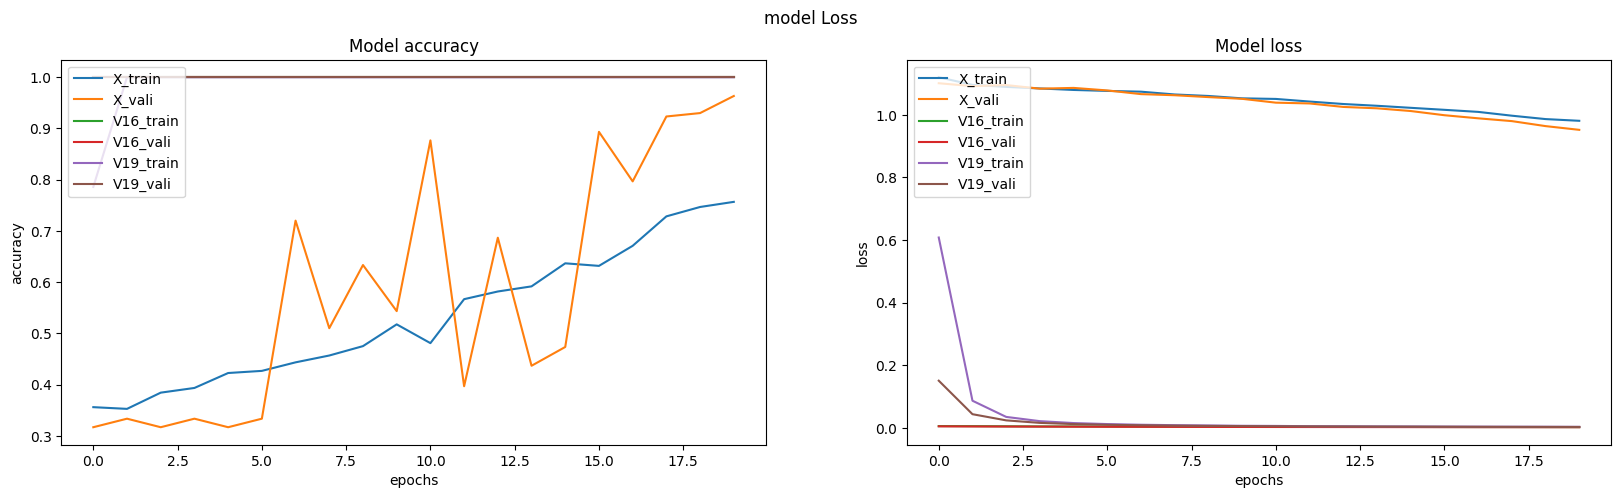

In [ ]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fig.suptitle('model Loss')

axs[0].plot(history_xception.history["categorical_accuracy"])
axs[0].plot(history_xception.history["val_categorical_accuracy"])
axs[0].plot(history_VGG16.history["categorical_accuracy"])
axs[0].plot(history_VGG16.history["val_categorical_accuracy"])
axs[0].plot(history_VGG19.history["categorical_accuracy"])
axs[0].plot(history_VGG19.history["val_categorical_accuracy"])
axs[0].legend(['X_train', 'X_vali', 'V16_train', 'V16_vali','V19_train', 'V19_vali'], loc='upper left')
axs[0].set_title('Model accuracy')
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("accuracy")

axs[1].plot(history_xception.history["loss"])
axs[1].plot(history_xception.history["val_loss"])
axs[1].plot(history_VGG16.history["loss"])
axs[1].plot(history_VGG16.history["val_loss"])
axs[1].plot(history_VGG19.history["loss"])
axs[1].plot(history_VGG19.history["val_loss"])
axs[1].legend(['X_train', 'X_vali', 'V16_train', 'V16_vali','V19_train', 'V19_vali'], loc='upper left')
axs[1].set_title('Model loss')
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("loss")

# **15. Créer le jeu de données de test**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset,
    seed=42,
    image_size=(299, 299),
    batch_size=batch_size,
    label_mode="categorical"
)

Found 300 files belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test avec la fonction evaluate()**

In [ ]:
test = model_xception.evaluate(test_ds)

38/38 [==============================] - 3s 66ms/step - loss: 0.3757 - categorical_accuracy: 0.8867


In [ ]:
test = model_VGG16.evaluate(test_ds)

38/38 [==============================] - 4s 94ms/step - loss: 0.3519 - categorical_accuracy: 0.9200


In [ ]:
test = model_VGG19.evaluate(test_ds)

38/38 [==============================] - 5s 119ms/step - loss: 0.4713 - categorical_accuracy: 0.8967


In [29]:
test = model_inceptionResnetV2.evaluate(test_ds)

AttributeError: ignored

In [30]:
test = model_InceptionV3.evaluate(test_ds)

AttributeError: ignored

#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

1/1 [==============================] - 0s 32ms/step
model= Xception
Class Name : fire --- Class Probability: 35.71%
model= Xception
Class Name : no_fire --- Class Probability: 34.03%
model= Xception
Class Name : start_fire --- Class Probability: 30.26%


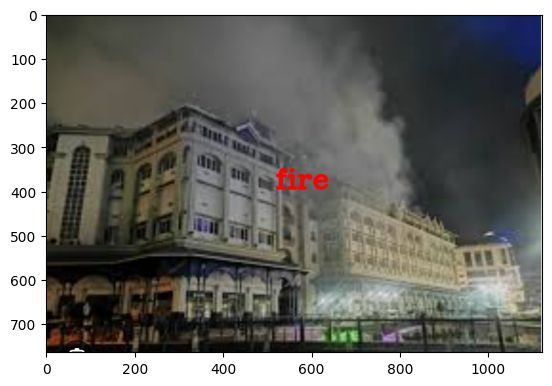

In [ ]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "maisonFeu.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model_xception.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("model= Xception")
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

1/1 [==============================] - 0s 18ms/step
model= VGG16
Class Name : fire --- Class Probability: 83.79%
model= VGG16
Class Name : no_fire --- Class Probability: 15.00%
model= VGG16
Class Name : start_fire --- Class Probability: 1.22%


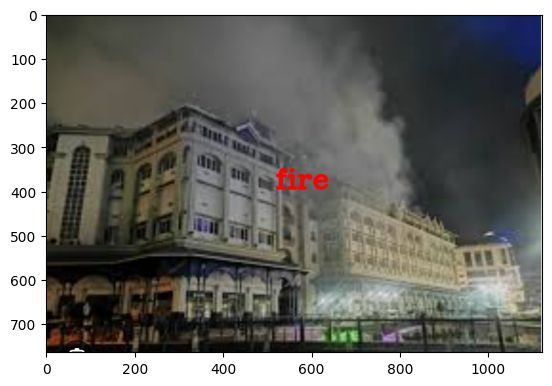

In [ ]:
classes = train_ds.class_names
image_path = "maisonFeu.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model_VGG16.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("model= VGG16")
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

1/1 [==============================] - 0s 28ms/step
model= VGG19
Class Name : fire --- Class Probability: 81.56%
model= VGG19
Class Name : no_fire --- Class Probability: 8.46%
model= VGG19
Class Name : start_fire --- Class Probability: 9.98%


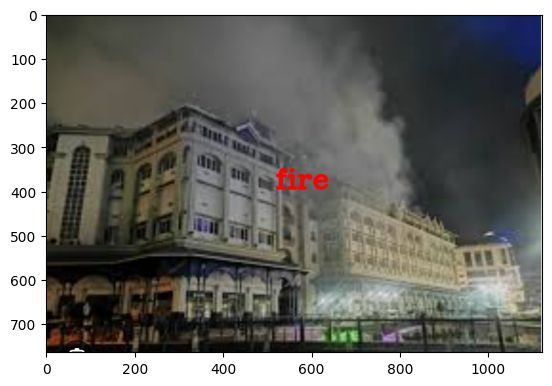

In [ ]:
classes = train_ds.class_names
image_path =  "maisonFeu.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)


# predict
pred = model_VGG19.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("model= VGG19")
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()